# **Proposed ECG-Classification Experiment**

**Imports**

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from sklearn.metrics import classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import label_binarize
from sklearn.model_selection import train_test_split

**ECG Dataset With Features**

1. Load signal & metadata

2. Remove classes with less than 120 samples

3. Map gender to integer

4. Drop rows with filename missing

5. Keep only desired tabular feature columns

6. Create integer label map for remaining rhythm classes

7. Load, shape-check & transpose each ECG file (12 × 5000)

8. Return {"signal", "label", "extra"} tensors for every sample





In [3]:
class ECGDatasetWithFeatures(Dataset):

    def __init__(self, diagnostics_file, ecg_folder, rhythm_names, tabular_features):
        self.ecg_folder = ecg_folder

        # --- Load RhythmNames.csv
        if not os.path.exists(rhythm_names):
            raise ValueError(f"rhythm_names file not found: {rhythm_names}")
        rhythm_df = pd.read_csv(rhythm_names)
        rhythm_df["Acronym Name"] = rhythm_df["Acronym Name"].str.strip()
        self.rhythm_mapping = rhythm_df.set_index("Acronym Name")["Full Name"].to_dict()
        print("Loaded RhythmNames mapping:", self.rhythm_mapping)

        # --- Load Diagnostics.csv
        df = pd.read_csv(diagnostics_file)
        if "FileName" not in df.columns or "Rhythm" not in df.columns:
            raise ValueError("Diagnostics.csv must have 'FileName' and 'Rhythm' columns.")

        valid_rows = []
        for _, row in df.iterrows():
            file_path = os.path.join(ecg_folder, f"{row['FileName']}.csv")
            if os.path.exists(file_path):
                valid_rows.append(row)
        df = pd.DataFrame(valid_rows)
        if len(df) == 0:
            raise ValueError("No valid ECG files found. Check Diagnostics.csv and folder paths.")


        # Filter out classes that have < 120 total samples
        counts = df["Rhythm"].value_counts()
        valid_rhythms = counts[counts >= 120].index  # array/list of rhythms with >=120
        df = df[df["Rhythm"].isin(valid_rhythms)]
        if len(df) == 0:
            raise ValueError("After excluding classes with <120 samples, no data remains.")

        self.data = df

        # Map Gender strings to 0/1 once, right after we load the dataframe
        if "Gender" in self.data.columns:
            gender_map = {
                "MALE": 1, "Male": 1, "male": 1, "m": 1, "M": 1,
                "FEMALE": 0, "Female": 0, "female": 0, "f": 0, "F": 0
            }
            # strip spaces & capitalise consistently
            self.data["Gender"] = (
                self.data["Gender"]
                .astype(str)

                .str.strip()
                .map(gender_map)
            )
            # handle missing / unknown values => impute with column mode (most common)
            if self.data["Gender"].isna().any():
                mode_val = int(self.data["Gender"].mode(dropna=True).iat[0])
                self.data["Gender"].fillna(mode_val, inplace=True)

        # Build label mapping from the final set of rhythms
        unique_rhythms = sorted(self.data["Rhythm"].unique())
        self.class_mapping = {rh: i for i, rh in enumerate(unique_rhythms)}
        print("Final included rhythms (each >= 120 total):")
        for rh in unique_rhythms:
            cnt = len(self.data[self.data["Rhythm"] == rh])
            print(f"  - {rh}: {cnt} rows")
        print("Built label mapping:", self.class_mapping)

        # Hard-coded feature columns
        self.desired_features = tabular_features
        self.feature_cols = [c for c in self.desired_features if c in self.data.columns]
        print("Using these feature columns:", self.feature_cols)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        file_name = row["FileName"]
        rhythm    = row["Rhythm"]
        csv_path = os.path.join(self.ecg_folder, f"{file_name}.csv")
        ecg_data = pd.read_csv(csv_path, header=None).values  # shape [5000,12]
        if ecg_data.shape != (5000, 12):
            raise ValueError(f"ECG file {csv_path} has shape {ecg_data.shape}, expected (5000,12).")

        ecg_data = ecg_data.T  # => [12,5000]
        label_idx = self.class_mapping[rhythm]

        if len(self.feature_cols) > 0:
            feats = row[self.feature_cols].values.astype(np.float32)
        else:
            feats = np.array([], dtype=np.float32)

        sample = {
            "signal": torch.tensor(ecg_data, dtype=torch.float32),  # [12,5000]
            "label" : torch.tensor(label_idx, dtype=torch.long),
            "extra" : torch.tensor(feats, dtype=torch.float32)
        }
        return sample

**Stratified Dataloaders**
1. Instantiate multimodal dataset (ECGDatasetWithFeatures)

2. Stratify indices by rhythm class

3. Split each class 70 % train 15 % 15 % test

4. Wrap splits in Subset objects

5. Compute inverse-frequency class weights from the train split

6. Build WeightedRandomSampler to balance training batches

7. Create DataLoaders sampled train, sequential val & test

In [4]:
def get_stratified_dataloaders(
    diagnostics_file, ecg_folder, rhythm_names,
    batch_size=8,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    tabular_features=None
):
    """
    - Builds the dataset (keeping all classes that have >=120 samples).
    - Splits into train/val/test by stratified logic.
    - Uses WeightedRandomSampler for the train set to mitigate class imbalance.
    """

    dataset = ECGDatasetWithFeatures(diagnostics_file, ecg_folder, rhythm_names, tabular_features)
    ds_size = len(dataset)

    # Stratify
    label_to_indices = {}
    for idx in range(ds_size):
        lbl = dataset[idx]["label"].item()
        if lbl not in label_to_indices:
            label_to_indices[lbl] = []
        label_to_indices[lbl].append(idx)

    train_indices = []
    val_indices   = []
    test_indices  = []

    for lbl, idx_list in label_to_indices.items():
        idx_arr = np.array(idx_list)
        np.random.shuffle(idx_arr)
        n_total = len(idx_arr)
        n_train = int(train_ratio * n_total)
        n_val   = int(val_ratio   * n_total)
        n_test  = n_total - n_train - n_val

        train_indices.extend(idx_arr[:n_train])
        val_indices.extend(idx_arr[n_train : n_train + n_val])
        test_indices.extend(idx_arr[n_train + n_val :])

    train_ds = Subset(dataset, train_indices)
    val_ds   = Subset(dataset, val_indices)
    test_ds  = Subset(dataset, test_indices)

    # Weighted sampler for the train set
    train_labels = []
    for idx in train_indices:
        lbl = dataset[idx]["label"].item()
        train_labels.append(lbl)
    train_labels = np.array(train_labels)
    class_counts = np.bincount(train_labels)
    class_weights = 1.0 / (class_counts + 1e-7)
    sample_weights = [class_weights[lbl] for lbl in train_labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

    print(f"Total dataset size: {ds_size}")
    print(f"Train split: {len(train_ds)} samples")
    print(f"Val   split: {len(val_ds)} samples")
    print(f"Test  split: {len(test_ds)} samples")
    return train_loader, val_loader, test_loader, dataset

**Model Architecture**
1. Residual 1-D CNN blocks (12 leads) with squeeze-and-excite attention extract waveform features

2. Bi-GRU layer to capture temporal patterns from extracted features

3. Optional MLP branch for extra tabular features

4. Late fusion with fully-connected layer








In [5]:
class SEBlockAvgMax(nn.Module):
    def __init__(self, channels, reduction=16,
                 mode='softmax',    # 'softmax' or 'sigmoid'
                 temperature=1.0):
        super().__init__()
        self.mode = mode
        self.temperature = temperature
        self.fc = nn.Sequential(
            nn.Linear(channels * 2, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels)
        )

    def forward(self, x):
        # x: [B, C, T]
        b, c, t = x.size()

        # 1) Squeeze
        avg = F.adaptive_avg_pool1d(x, 1).view(b, c)
        mx  = F.adaptive_max_pool1d(x, 1).view(b, c)
        z   = torch.cat([avg, mx], dim=1)           # [B, 2C]

        # 2) Excitation (pre‑activation)
        logits = self.fc(z)                         # [B, C]

        if self.mode == 'softmax':
            # a) Softmax over channels
            excitation = F.softmax(logits, dim=1).view(b, c, 1)
        else:
            # b) Sigmoid with temperature
            excitation = torch.sigmoid(logits / self.temperature).view(b, c, 1)

        # 3) Scale
        out = x * excitation
        return out, excitation


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.se    = SEBlockAvgMax(out_channels, reduction=reduction)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out, se_weights = self.se(out)
        if self.shortcut is not None:
            identity = self.shortcut(identity)
        out += identity
        return F.relu(out), se_weights

class ECGwithFeaturesModelV2(nn.Module):
    def __init__(self, num_classes, num_extra_features):
        super().__init__()

        # Convolutional backbone
        self.block1   = ResidualBlock(12,  64, 1);  self.block1b = ResidualBlock(64,  64, 1)
        self.drop1b   = nn.Dropout1d(0.2)

        self.block2   = ResidualBlock(64, 128, 2);  self.block2b = ResidualBlock(128,128,1)
        self.cbam_spatial2 = nn.Conv1d(2, 1, 7, padding=3)
        self.drop2b   = nn.Dropout1d(0.2)


        self.block3   = ResidualBlock(128,256,2);   self.block3b = ResidualBlock(256,256,1)
        self.drop3b   = nn.Dropout1d(0.2)

        self.block4   = ResidualBlock(256,512,2);   self.block4b = ResidualBlock(512,512,1)
        self.drop4b   = nn.Dropout1d(0.2)

        # bidirectional GRU over the time axis
        self.rnn = nn.GRU(
            input_size = 512,   # channels coming from conv backbone
            hidden_size= 128,   # you can tune this
            num_layers = 2,
            batch_first = True,
            bidirectional = True,
            dropout = 0.2
        )                       # output dim = 128*2 = 256

        # FC head
        self.fc_dropout = nn.Dropout(0.5)
        self.cnn_fc     = nn.Linear(256, 256)       # from bi‑GRU

        mlp = []
        if num_extra_features > 0:
            mlp += [
                nn.Linear(num_extra_features, 128),
                nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            ]
        self.features_fc = nn.Sequential(*mlp)

        final_dim = 256 + (64 if num_extra_features else 0)
        self.classifier = nn.Linear(final_dim, num_classes)

    def forward(self, x, extra):
        se_attns = []

        # Conv / SE / CBAM backbone
        out, se = self.block1(x);    se_attns.append(se)
        out, se = self.block1b(out); se_attns.append(se); out = self.drop1b(out)

        out, se = self.block2(out);  se_attns.append(se)
        out, se = self.block2b(out); se_attns.append(se)
        avg, mx = out.mean(1,True), out.max(1,True).values
        out = out * torch.sigmoid(self.cbam_spatial2(torch.cat([avg,mx],1)))
        out = self.drop2b(out)

        out, se = self.block3(out);  se_attns.append(se)
        out, se = self.block3b(out); se_attns.append(se); out = self.drop3b(out)

        out, se = self.block4(out);  se_attns.append(se)
        out, se = self.block4b(out); se_attns.append(se); out = self.drop4b(out)
        # shape: [B, 512, T]

        # GRU over time
        out = out.permute(0, 2, 1)            # [B, T, 512]  (batch_first=True)
        rnn_out, _ = self.rnn(out)            # [B, T, 256]
        feat = rnn_out.mean(dim=1)            # temporal mean‑pool => [B,256]

        # FC head & extras
        feat = self.fc_dropout(F.relu(self.cnn_fc(feat)))  # [B,256]

        if extra.size(1) > 0:
            feat_extra = self.features_fc(extra)           # [B,64]
            feat       = torch.cat([feat, feat_extra], 1)  # [B,320]

        logits = self.classifier(feat)
        return logits, se_attns



**Train and Evaluate**
1. Training setup with AdamW optimiser, Reduce-LR-on-Plateau scheduler, label-smoothed Cross-Entropy

2. Epoch loop forward => back-prop => update. Track running loss & accuracy

3. Validation each epoch and compute loss / acc, update best-model checkpoint, early-stop after 6 stagnant epochs

4. Post-training save PNG plots of loss-and-accuracy curves

6. Evaluate_model containing full test suite: SE-attention bar plots, per-class report, confusion-matrix heat-map, ROC curves, and macro metrics saved to disk

In [6]:
def train_model(model, train_loader, val_loader, device,
                epochs=10, lr=1e-3, weight_decay=1e-5, output_dir="drive/MyDrive/results"):

    os.makedirs(output_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=os.path.join(output_dir, "runs"))

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # didnt have label smoothing

    best_val_loss = float('inf')
    patience_counter = 0
    patience_limit = 6

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            signals = batch["signal"].to(device)
            labels = batch["label"].to(device)
            extras = batch["extra"].to(device)

            optimizer.zero_grad()
            outputs, _ = model(signals, extras)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = evaluate_accuracy(model, val_loader, device, return_loss=True)

        # Logging
        writer.add_scalar("Loss/Train", avg_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch}: Train Loss={avg_loss:.4f}, Train Acc={train_acc*100:.2f}% | "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(output_dir, "best_model.pt"))
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping at epoch {epoch}")
                break

    writer.close()

    # Plot curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_curves.png"))
    plt.show()

def evaluate_accuracy(model, loader, device, return_loss=False):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # didnt have label smoothing

    with torch.no_grad():
        for batch in loader:
            signals = batch["signal"].to(device)
            labels  = batch["label"].to(device)
            extras  = batch["extra"].to(device)
            logits, _  = model(signals, extras)
            loss    = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            loss_total += loss.item()

    acc = correct / total if total else 0.0
    avg_loss = loss_total / len(loader)

    return (acc, avg_loss) if return_loss else acc

def plot_se_attention(vec, names=None, save=None, title="SE Channel Attention", n_ticks=10):
    names = names or [str(i+1) for i in range(len(vec))]
    N = len(vec)

    # decide how many labels to show (max n_ticks)
    step = max(1, N // n_ticks)
    ticks = list(range(0, N, step))
    if ticks[-1] != N-1:
        ticks.append(N-1)

    plt.figure(figsize=(10,4))
    # draw every bar
    plt.bar(range(N), vec, color='steelblue')
    plt.ylim(0,1)
    plt.xlabel("Feature‑Map Channel")
    plt.ylabel("Weight")
    plt.title(title)

    # only label at our chosen ticks
    plt.xticks(ticks, [names[i] for i in ticks], rotation=45)
    plt.tight_layout()

    if save:
        plt.savefig(save)
        plt.close()
    else:
        plt.show()


def evaluate_model(model, test_loader, num_classes, device, class_names=None, output_dir="drive/MyDrive/results"):
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    attention_visuals = []

    with torch.no_grad():
        first_batch = True
        for batch in test_loader:
            signals = batch["signal"].to(device)
            labels = batch["label"].to(device)
            extras = batch["extra"].to(device)

            logits, se_attns = model(signals, extras)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 1) SE channel bars—only for the first batch
            if first_batch:
                for blk_idx, se in enumerate(se_attns):
                    vec = se[0].squeeze().cpu().numpy()  # channels
                    plot_se_attention(
                        vec,
                        names=[f"{i+1}" for i in range(len(vec))],
                        save=os.path.join(output_dir, f"se_block{blk_idx+1}_sample0.png"),
                        title=f"SE Attention – Block {blk_idx+1}"
                    )
                first_batch = False

    # Metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)


    # Text Report
    report_str = classification_report(
        y_true,
        y_pred,
        target_names=[str(n) for n in (class_names or [])],
        digits=4,
        zero_division=0
    )


    print("\nPer‑class classification report:\n")
    print(report_str)


    report_path = os.path.join(output_dir, "classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report_str)


    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred)

    # ROC AUC
    roc_auc = None
    if len(np.unique(y_true)) > 1:
        one_hot = np.eye(num_classes)[y_true]
        try:
            roc_auc = roc_auc_score(one_hot, y_prob, multi_class="ovr", average="macro")

            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(one_hot[:, i], y_prob[:, i])
                label = f"{class_names[i]} (AUC={auc(fpr, tpr):.2f})" if class_names else f"Class {i}"
                plt.plot(fpr, tpr, label=label)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curves")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(output_dir, "roc_curves.png"))
            plt.close()
        except ValueError:
            pass

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else None,
                yticklabels=class_names if class_names else None)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.close()

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }
    for k, v in metrics.items():
        print(f"{k.title():<12}: {v:.4f}" if v is not None else f"{k.title():<12}: Not computed")

    with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n" if v is not None else f"{k}: Not computed\n")

    return accuracy, roc_auc



**Mult-Modal Deep Learning Model for Multi-Classification Arrythmia Detection**

1. Define file paths & list of tabular feature columns

2. Set training hyper-parameters

3. Build stratified train/val/test loaders

4. Get num_classes + num_features from the dataset

5. Instantiate Model (CNN-GRU + tabular branch)

6. Train the model with early-stopping and LR scheduling

7. Evaluate on the held-out test set

Using device: cuda
Loaded RhythmNames mapping: {'SA': 'Sinus Arrhythmia', 'SB': 'Sinus Bradycardia', 'SR': 'Sinus Rhythm', 'AFIB': 'Atrial Fibrillation', 'ST': 'Sinus Tachycardia', 'AF': 'Atrial Flutter', 'SVT': 'Supraventricular Tachycardia', 'AT': 'Atrial Tachycardia', 'AVNRT': 'Atrioventricular  Node Reentrant Tachycardia', 'AVRT': 'Atrioventricular Reentrant Tachycardia', 'SAAWR': 'Sinus Atrium to Atrial Wandering Rhythm'}
Final included rhythms (each >= 120 total):
  - AF: 438 rows
  - AFIB: 1780 rows
  - AT: 121 rows
  - SA: 397 rows
  - SB: 3888 rows
  - SR: 1825 rows
  - ST: 1564 rows
  - SVT: 584 rows
Built label mapping: {'AF': 0, 'AFIB': 1, 'AT': 2, 'SA': 3, 'SB': 4, 'SR': 5, 'ST': 6, 'SVT': 7}
Using these feature columns: ['PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']
Total dataset size: 10597
Train split: 7413 samples
Val   split: 1586 samples
Test  split: 1

Epoch 1/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 1: Train Loss=1.8431, Train Acc=31.38% | Val Loss=1.3945, Val Acc=63.32%


Epoch 2/100: 100%|██████████| 926/926 [01:49<00:00,  8.48it/s]


Epoch 2: Train Loss=1.5126, Train Acc=48.81% | Val Loss=1.1327, Val Acc=75.69%


Epoch 3/100: 100%|██████████| 926/926 [01:49<00:00,  8.49it/s]


Epoch 3: Train Loss=1.3258, Train Acc=58.06% | Val Loss=0.9279, Val Acc=82.58%


Epoch 4/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 4: Train Loss=1.1903, Train Acc=64.71% | Val Loss=0.9072, Val Acc=83.21%


Epoch 5/100: 100%|██████████| 926/926 [01:50<00:00,  8.36it/s]


Epoch 5: Train Loss=1.1037, Train Acc=69.42% | Val Loss=0.8248, Val Acc=86.49%


Epoch 6/100: 100%|██████████| 926/926 [01:48<00:00,  8.51it/s]


Epoch 6: Train Loss=1.0377, Train Acc=72.91% | Val Loss=0.8084, Val Acc=86.24%


Epoch 7/100: 100%|██████████| 926/926 [01:55<00:00,  8.02it/s]


Epoch 7: Train Loss=0.9942, Train Acc=75.57% | Val Loss=0.7799, Val Acc=88.07%


Epoch 8/100: 100%|██████████| 926/926 [01:48<00:00,  8.54it/s]


Epoch 8: Train Loss=0.9696, Train Acc=76.75% | Val Loss=0.7707, Val Acc=88.01%


Epoch 9/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 9: Train Loss=0.9183, Train Acc=79.67% | Val Loss=0.7733, Val Acc=86.93%


Epoch 10/100: 100%|██████████| 926/926 [01:47<00:00,  8.57it/s]


Epoch 10: Train Loss=0.9026, Train Acc=80.02% | Val Loss=0.7536, Val Acc=88.70%


Epoch 11/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 11: Train Loss=0.8913, Train Acc=80.37% | Val Loss=0.7542, Val Acc=88.26%


Epoch 12/100: 100%|██████████| 926/926 [01:48<00:00,  8.56it/s]


Epoch 12: Train Loss=0.8651, Train Acc=81.76% | Val Loss=0.7406, Val Acc=89.27%


Epoch 13/100: 100%|██████████| 926/926 [01:48<00:00,  8.54it/s]


Epoch 13: Train Loss=0.8317, Train Acc=83.76% | Val Loss=0.7599, Val Acc=88.32%


Epoch 14/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 14: Train Loss=0.8339, Train Acc=83.99% | Val Loss=0.7394, Val Acc=88.45%


Epoch 15/100: 100%|██████████| 926/926 [01:48<00:00,  8.54it/s]


Epoch 15: Train Loss=0.8204, Train Acc=84.77% | Val Loss=0.7418, Val Acc=88.07%


Epoch 16/100: 100%|██████████| 926/926 [01:47<00:00,  8.61it/s]


Epoch 16: Train Loss=0.8102, Train Acc=84.72% | Val Loss=0.7187, Val Acc=89.52%


Epoch 17/100: 100%|██████████| 926/926 [01:48<00:00,  8.56it/s]


Epoch 17: Train Loss=0.7919, Train Acc=85.58% | Val Loss=0.7284, Val Acc=88.70%


Epoch 18/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 18: Train Loss=0.7885, Train Acc=85.11% | Val Loss=0.7169, Val Acc=90.09%


Epoch 19/100: 100%|██████████| 926/926 [01:47<00:00,  8.57it/s]


Epoch 19: Train Loss=0.7744, Train Acc=87.04% | Val Loss=0.7413, Val Acc=88.64%


Epoch 20/100: 100%|██████████| 926/926 [01:48<00:00,  8.55it/s]


Epoch 20: Train Loss=0.7750, Train Acc=86.61% | Val Loss=0.7058, Val Acc=89.84%


Epoch 21/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 21: Train Loss=0.7566, Train Acc=87.81% | Val Loss=0.7194, Val Acc=89.71%


Epoch 22/100: 100%|██████████| 926/926 [01:47<00:00,  8.58it/s]


Epoch 22: Train Loss=0.7411, Train Acc=88.43% | Val Loss=0.7106, Val Acc=90.09%


Epoch 23/100: 100%|██████████| 926/926 [01:47<00:00,  8.58it/s]


Epoch 23: Train Loss=0.7424, Train Acc=88.04% | Val Loss=0.7574, Val Acc=87.12%


Epoch 24/100: 100%|██████████| 926/926 [01:47<00:00,  8.59it/s]


Epoch 24: Train Loss=0.7219, Train Acc=89.77% | Val Loss=0.6946, Val Acc=90.72%


Epoch 25/100: 100%|██████████| 926/926 [01:48<00:00,  8.55it/s]


Epoch 25: Train Loss=0.7286, Train Acc=89.19% | Val Loss=0.7054, Val Acc=89.84%


Epoch 26/100: 100%|██████████| 926/926 [01:47<00:00,  8.58it/s]


Epoch 26: Train Loss=0.7169, Train Acc=89.92% | Val Loss=0.7010, Val Acc=90.21%


Epoch 27/100: 100%|██████████| 926/926 [01:47<00:00,  8.61it/s]


Epoch 27: Train Loss=0.7098, Train Acc=90.19% | Val Loss=0.6982, Val Acc=90.97%


Epoch 28/100: 100%|██████████| 926/926 [01:48<00:00,  8.56it/s]


Epoch 28: Train Loss=0.6949, Train Acc=91.23% | Val Loss=0.6995, Val Acc=90.72%


Epoch 29/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 29: Train Loss=0.6742, Train Acc=92.22% | Val Loss=0.6775, Val Acc=91.29%


Epoch 30/100: 100%|██████████| 926/926 [01:48<00:00,  8.52it/s]


Epoch 30: Train Loss=0.6581, Train Acc=92.98% | Val Loss=0.6722, Val Acc=91.86%


Epoch 31/100: 100%|██████████| 926/926 [01:47<00:00,  8.58it/s]


Epoch 31: Train Loss=0.6596, Train Acc=92.51% | Val Loss=0.6780, Val Acc=91.41%


Epoch 32/100: 100%|██████████| 926/926 [01:47<00:00,  8.61it/s]


Epoch 32: Train Loss=0.6475, Train Acc=93.84% | Val Loss=0.6762, Val Acc=91.73%


Epoch 33/100: 100%|██████████| 926/926 [01:48<00:00,  8.55it/s]


Epoch 33: Train Loss=0.6523, Train Acc=93.25% | Val Loss=0.6849, Val Acc=91.29%


Epoch 34/100: 100%|██████████| 926/926 [01:47<00:00,  8.58it/s]


Epoch 34: Train Loss=0.6503, Train Acc=92.87% | Val Loss=0.6728, Val Acc=91.79%


Epoch 35/100: 100%|██████████| 926/926 [01:49<00:00,  8.47it/s]


Epoch 35: Train Loss=0.6408, Train Acc=93.60% | Val Loss=0.6692, Val Acc=92.11%


Epoch 36/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 36: Train Loss=0.6298, Train Acc=94.28% | Val Loss=0.6720, Val Acc=91.98%


Epoch 37/100: 100%|██████████| 926/926 [01:47<00:00,  8.59it/s]


Epoch 37: Train Loss=0.6383, Train Acc=93.95% | Val Loss=0.6742, Val Acc=91.86%


Epoch 38/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 38: Train Loss=0.6367, Train Acc=93.71% | Val Loss=0.6688, Val Acc=91.98%


Epoch 39/100: 100%|██████████| 926/926 [01:48<00:00,  8.57it/s]


Epoch 39: Train Loss=0.6477, Train Acc=93.29% | Val Loss=0.6680, Val Acc=91.98%


Epoch 40/100: 100%|██████████| 926/926 [01:48<00:00,  8.53it/s]


Epoch 40: Train Loss=0.6322, Train Acc=94.21% | Val Loss=0.6634, Val Acc=92.61%


Epoch 41/100: 100%|██████████| 926/926 [01:48<00:00,  8.52it/s]


Epoch 41: Train Loss=0.6336, Train Acc=94.37% | Val Loss=0.6653, Val Acc=92.36%


Epoch 42/100: 100%|██████████| 926/926 [01:47<00:00,  8.59it/s]


Epoch 42: Train Loss=0.6340, Train Acc=93.86% | Val Loss=0.6682, Val Acc=92.05%


Epoch 43/100: 100%|██████████| 926/926 [01:48<00:00,  8.55it/s]


Epoch 43: Train Loss=0.6416, Train Acc=93.37% | Val Loss=0.6653, Val Acc=92.11%


Epoch 44/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 44: Train Loss=0.6344, Train Acc=93.99% | Val Loss=0.6647, Val Acc=91.79%


Epoch 45/100: 100%|██████████| 926/926 [01:48<00:00,  8.55it/s]


Epoch 45: Train Loss=0.6223, Train Acc=94.78% | Val Loss=0.6631, Val Acc=92.17%


Epoch 46/100: 100%|██████████| 926/926 [01:48<00:00,  8.56it/s]


Epoch 46: Train Loss=0.6261, Train Acc=94.20% | Val Loss=0.6674, Val Acc=91.79%


Epoch 47/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 47: Train Loss=0.6330, Train Acc=94.18% | Val Loss=0.6683, Val Acc=92.05%


Epoch 48/100: 100%|██████████| 926/926 [01:48<00:00,  8.53it/s]


Epoch 48: Train Loss=0.6279, Train Acc=94.40% | Val Loss=0.6663, Val Acc=91.98%


Epoch 49/100: 100%|██████████| 926/926 [01:48<00:00,  8.56it/s]


Epoch 49: Train Loss=0.6275, Train Acc=94.52% | Val Loss=0.6684, Val Acc=91.98%


Epoch 50/100: 100%|██████████| 926/926 [01:50<00:00,  8.41it/s]


Epoch 50: Train Loss=0.6288, Train Acc=94.29% | Val Loss=0.6675, Val Acc=92.05%


Epoch 51/100: 100%|██████████| 926/926 [01:49<00:00,  8.49it/s]


Epoch 51: Train Loss=0.6315, Train Acc=94.02% | Val Loss=0.6667, Val Acc=92.05%
Early stopping at epoch 51


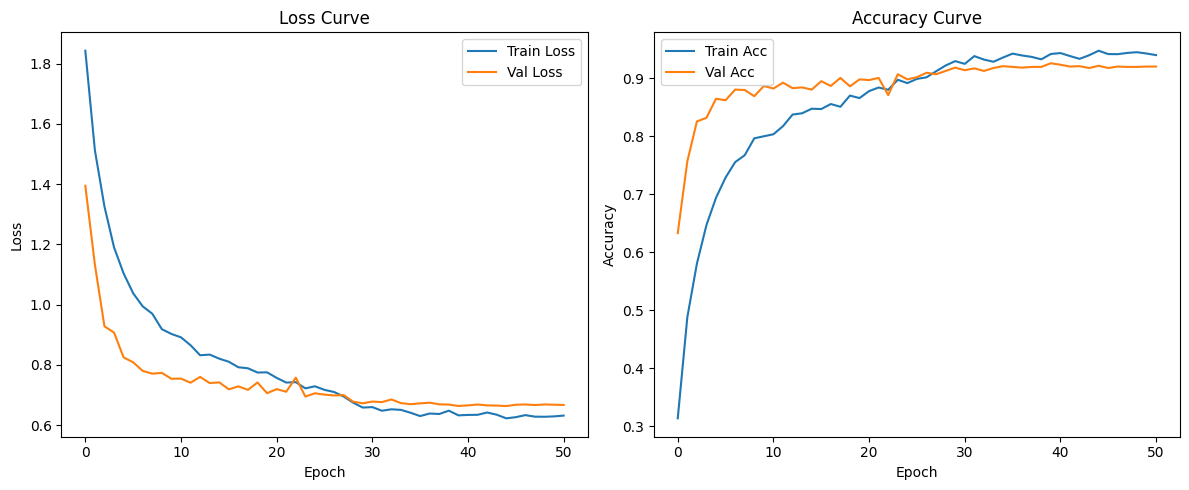


Per‑class classification report:

              precision    recall  f1-score   support

          AF     0.6724    0.5821    0.6240        67
        AFIB     0.8889    0.9588    0.9225       267
          AT     0.5455    0.4615    0.5000        13
          SA     0.6618    0.7377    0.6977        61
          SB     0.9729    0.9829    0.9779       584
          SR     0.9286    0.8509    0.8880       275
          ST     0.9571    0.9449    0.9510       236
         SVT     0.8804    0.9101    0.8950        89

    accuracy                         0.9158      1592
   macro avg     0.8134    0.8036    0.8070      1592
weighted avg     0.9156    0.9158    0.9149      1592

Accuracy    : 0.9158
Precision   : 0.8134
Recall      : 0.8036
F1_Score    : 0.8070
Roc_Auc     : 0.9784

Test Accuracy: 0.9158
Test ROC-AUC: 0.9784


In [13]:
def main():
    diagnostics_file = "/content/drive/MyDrive/Diagnostics.csv"
    ecg_folder       = "/content/drive/MyDrive/ECGDataDenoisedDownloaded"
    rhythm_names     = "/content/drive/MyDrive/RhythmNames.csv"

    tabular_features = ["PatientAge", "Gender", "VentricularRate", "AtrialRate", "QRSDuration",
            "QTInterval", "QTCorrected", "RAxis", "TAxis", "QRSCount",
            "QOnset", "QOffset", "TOffset"]

    # Hyperparams
    batch_size   = 8
    epochs       = 100
    learning_rate= 9e-5
    weight_decay = 7e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Build DataLoaders with WeightedRandomSampler for the train set
    train_loader, val_loader, test_loader, full_dataset = get_stratified_dataloaders(
        diagnostics_file, ecg_folder, rhythm_names,
        batch_size=batch_size,
        tabular_features=tabular_features
    )

    num_classes = len(full_dataset.class_mapping)
    print(f"Number of classes in final dataset: {num_classes}")

    num_features = len(full_dataset.feature_cols)
    print(f"Number of numeric features: {num_features}")

    # Build the CNN
    model = ECGwithFeaturesModelV2(num_classes, num_features)

    # Train
    train_model(model, train_loader, val_loader,
                device, epochs=epochs, lr=learning_rate, weight_decay=weight_decay)

    # Evaluate
    class_names = sorted(full_dataset.class_mapping,
                     key=full_dataset.class_mapping.get)
    test_accuracy, test_roc_auc = evaluate_model(model, test_loader, num_classes, device, class_names=class_names)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    if test_roc_auc is not None:
        print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    else:
        print("ROC-AUC not computed (likely only one class).")

if __name__ == "__main__":
    main()


**Comparison Model with Signal Only Data**
1. Define file paths & empty tabular feature columns

2. Set training hyper-parameters

3. Build stratified train/val/test loaders

4. Get num_classes + num_features from the dataset

5. Instantiate Model (CNN-GRU)

6. Train the model with early-stopping and LR scheduling

7. Evaluate on the held-out test set

Using device: cuda
Loaded RhythmNames mapping: {'SA': 'Sinus Arrhythmia', 'SB': 'Sinus Bradycardia', 'SR': 'Sinus Rhythm', 'AFIB': 'Atrial Fibrillation', 'ST': 'Sinus Tachycardia', 'AF': 'Atrial Flutter', 'SVT': 'Supraventricular Tachycardia', 'AT': 'Atrial Tachycardia', 'AVNRT': 'Atrioventricular  Node Reentrant Tachycardia', 'AVRT': 'Atrioventricular Reentrant Tachycardia', 'SAAWR': 'Sinus Atrium to Atrial Wandering Rhythm'}
Final included rhythms (each >= 120 total):
  - AF: 438 rows
  - AFIB: 1780 rows
  - AT: 121 rows
  - SA: 397 rows
  - SB: 3888 rows
  - SR: 1825 rows
  - ST: 1564 rows
  - SVT: 584 rows
Built label mapping: {'AF': 0, 'AFIB': 1, 'AT': 2, 'SA': 3, 'SB': 4, 'SR': 5, 'ST': 6, 'SVT': 7}
Using these feature columns: []
Total dataset size: 10597
Train split: 7413 samples
Val   split: 1586 samples
Test  split: 1598 samples
Number of classes in final dataset: 8
Number of numeric features: 0


Epoch 1/100: 100%|██████████| 926/926 [01:45<00:00,  8.78it/s]


Epoch 1: Train Loss=1.8953, Train Acc=25.78% | Val Loss=1.5264, Val Acc=63.26%


Epoch 2/100: 100%|██████████| 926/926 [01:45<00:00,  8.78it/s]


Epoch 2: Train Loss=1.6019, Train Acc=43.09% | Val Loss=1.3152, Val Acc=61.93%


Epoch 3/100: 100%|██████████| 926/926 [01:46<00:00,  8.72it/s]


Epoch 3: Train Loss=1.4013, Train Acc=52.94% | Val Loss=1.0555, Val Acc=78.09%


Epoch 4/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 4: Train Loss=1.2148, Train Acc=62.22% | Val Loss=0.8902, Val Acc=83.02%


Epoch 5/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 5: Train Loss=1.1389, Train Acc=67.18% | Val Loss=0.8764, Val Acc=83.96%


Epoch 6/100: 100%|██████████| 926/926 [01:46<00:00,  8.72it/s]


Epoch 6: Train Loss=1.0622, Train Acc=70.03% | Val Loss=0.8222, Val Acc=86.74%


Epoch 7/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 7: Train Loss=1.0230, Train Acc=73.88% | Val Loss=0.8084, Val Acc=86.87%


Epoch 8/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 8: Train Loss=0.9824, Train Acc=75.62% | Val Loss=0.7750, Val Acc=87.82%


Epoch 9/100: 100%|██████████| 926/926 [01:45<00:00,  8.75it/s]


Epoch 9: Train Loss=0.9607, Train Acc=76.35% | Val Loss=0.7644, Val Acc=88.13%


Epoch 10/100: 100%|██████████| 926/926 [01:45<00:00,  8.75it/s]


Epoch 10: Train Loss=0.9098, Train Acc=79.50% | Val Loss=0.7787, Val Acc=86.55%


Epoch 11/100: 100%|██████████| 926/926 [01:45<00:00,  8.79it/s]


Epoch 11: Train Loss=0.8916, Train Acc=80.09% | Val Loss=0.7578, Val Acc=87.25%


Epoch 12/100: 100%|██████████| 926/926 [01:46<00:00,  8.71it/s]


Epoch 12: Train Loss=0.8603, Train Acc=82.15% | Val Loss=0.7742, Val Acc=87.18%


Epoch 13/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 13: Train Loss=0.8613, Train Acc=82.18% | Val Loss=0.7456, Val Acc=88.76%


Epoch 14/100: 100%|██████████| 926/926 [01:45<00:00,  8.80it/s]


Epoch 14: Train Loss=0.8491, Train Acc=82.94% | Val Loss=0.7734, Val Acc=85.98%


Epoch 15/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 15: Train Loss=0.8253, Train Acc=83.41% | Val Loss=0.7661, Val Acc=87.94%


Epoch 16/100: 100%|██████████| 926/926 [01:45<00:00,  8.80it/s]


Epoch 16: Train Loss=0.8152, Train Acc=84.38% | Val Loss=0.7284, Val Acc=88.76%


Epoch 17/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 17: Train Loss=0.7947, Train Acc=85.76% | Val Loss=0.7317, Val Acc=88.38%


Epoch 18/100: 100%|██████████| 926/926 [01:44<00:00,  8.88it/s]


Epoch 18: Train Loss=0.7978, Train Acc=85.48% | Val Loss=0.7302, Val Acc=89.08%


Epoch 19/100: 100%|██████████| 926/926 [01:44<00:00,  8.85it/s]


Epoch 19: Train Loss=0.7848, Train Acc=85.57% | Val Loss=0.7575, Val Acc=86.81%


Epoch 20/100: 100%|██████████| 926/926 [01:44<00:00,  8.87it/s]


Epoch 20: Train Loss=0.7718, Train Acc=86.81% | Val Loss=0.7449, Val Acc=88.26%


Epoch 21/100: 100%|██████████| 926/926 [01:43<00:00,  8.93it/s]


Epoch 21: Train Loss=0.7471, Train Acc=87.97% | Val Loss=0.7371, Val Acc=88.95%


Epoch 22/100: 100%|██████████| 926/926 [01:45<00:00,  8.77it/s]


Epoch 22: Train Loss=0.7393, Train Acc=88.57% | Val Loss=0.7221, Val Acc=89.65%


Epoch 23/100: 100%|██████████| 926/926 [01:46<00:00,  8.66it/s]


Epoch 23: Train Loss=0.7289, Train Acc=89.36% | Val Loss=0.7188, Val Acc=89.46%


Epoch 24/100: 100%|██████████| 926/926 [01:47<00:00,  8.60it/s]


Epoch 24: Train Loss=0.7198, Train Acc=89.48% | Val Loss=0.7149, Val Acc=90.03%


Epoch 25/100: 100%|██████████| 926/926 [01:45<00:00,  8.81it/s]


Epoch 25: Train Loss=0.7176, Train Acc=89.70% | Val Loss=0.7218, Val Acc=89.02%


Epoch 26/100: 100%|██████████| 926/926 [01:44<00:00,  8.84it/s]


Epoch 26: Train Loss=0.7175, Train Acc=89.82% | Val Loss=0.7168, Val Acc=89.96%


Epoch 27/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 27: Train Loss=0.7201, Train Acc=89.54% | Val Loss=0.7296, Val Acc=89.14%


Epoch 28/100: 100%|██████████| 926/926 [01:44<00:00,  8.83it/s]


Epoch 28: Train Loss=0.7043, Train Acc=90.32% | Val Loss=0.7106, Val Acc=90.34%


Epoch 29/100: 100%|██████████| 926/926 [01:45<00:00,  8.80it/s]


Epoch 29: Train Loss=0.7043, Train Acc=90.56% | Val Loss=0.7070, Val Acc=90.21%


Epoch 30/100: 100%|██████████| 926/926 [01:46<00:00,  8.68it/s]


Epoch 30: Train Loss=0.7030, Train Acc=90.44% | Val Loss=0.7263, Val Acc=89.27%


Epoch 31/100: 100%|██████████| 926/926 [01:46<00:00,  8.73it/s]


Epoch 31: Train Loss=0.6965, Train Acc=90.79% | Val Loss=0.7036, Val Acc=90.15%


Epoch 32/100: 100%|██████████| 926/926 [01:47<00:00,  8.64it/s]


Epoch 32: Train Loss=0.7023, Train Acc=90.70% | Val Loss=0.7244, Val Acc=89.52%


Epoch 33/100: 100%|██████████| 926/926 [01:45<00:00,  8.79it/s]


Epoch 33: Train Loss=0.6947, Train Acc=90.98% | Val Loss=0.7032, Val Acc=89.65%


Epoch 34/100: 100%|██████████| 926/926 [01:46<00:00,  8.72it/s]


Epoch 34: Train Loss=0.6925, Train Acc=91.25% | Val Loss=0.7058, Val Acc=90.21%


Epoch 35/100: 100%|██████████| 926/926 [01:44<00:00,  8.87it/s]


Epoch 35: Train Loss=0.6873, Train Acc=91.09% | Val Loss=0.7370, Val Acc=88.64%


Epoch 36/100: 100%|██████████| 926/926 [01:45<00:00,  8.79it/s]


Epoch 36: Train Loss=0.6764, Train Acc=91.93% | Val Loss=0.7311, Val Acc=89.77%


Epoch 37/100: 100%|██████████| 926/926 [01:44<00:00,  8.83it/s]


Epoch 37: Train Loss=0.6888, Train Acc=91.52% | Val Loss=0.7082, Val Acc=89.77%


Epoch 38/100: 100%|██████████| 926/926 [01:45<00:00,  8.80it/s]


Epoch 38: Train Loss=0.6761, Train Acc=92.00% | Val Loss=0.6986, Val Acc=90.47%


Epoch 39/100: 100%|██████████| 926/926 [01:45<00:00,  8.79it/s]


Epoch 39: Train Loss=0.6752, Train Acc=91.74% | Val Loss=0.7067, Val Acc=90.28%


Epoch 40/100: 100%|██████████| 926/926 [01:46<00:00,  8.70it/s]


Epoch 40: Train Loss=0.6822, Train Acc=91.63% | Val Loss=0.7110, Val Acc=89.65%


Epoch 41/100: 100%|██████████| 926/926 [01:46<00:00,  8.72it/s]


Epoch 41: Train Loss=0.6753, Train Acc=91.78% | Val Loss=0.7051, Val Acc=89.52%


Epoch 42/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 42: Train Loss=0.6667, Train Acc=92.31% | Val Loss=0.7050, Val Acc=90.21%


Epoch 43/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 43: Train Loss=0.6681, Train Acc=92.33% | Val Loss=0.7006, Val Acc=90.09%


Epoch 44/100: 100%|██████████| 926/926 [01:45<00:00,  8.76it/s]


Epoch 44: Train Loss=0.6749, Train Acc=91.83% | Val Loss=0.7009, Val Acc=89.96%
Early stopping at epoch 44


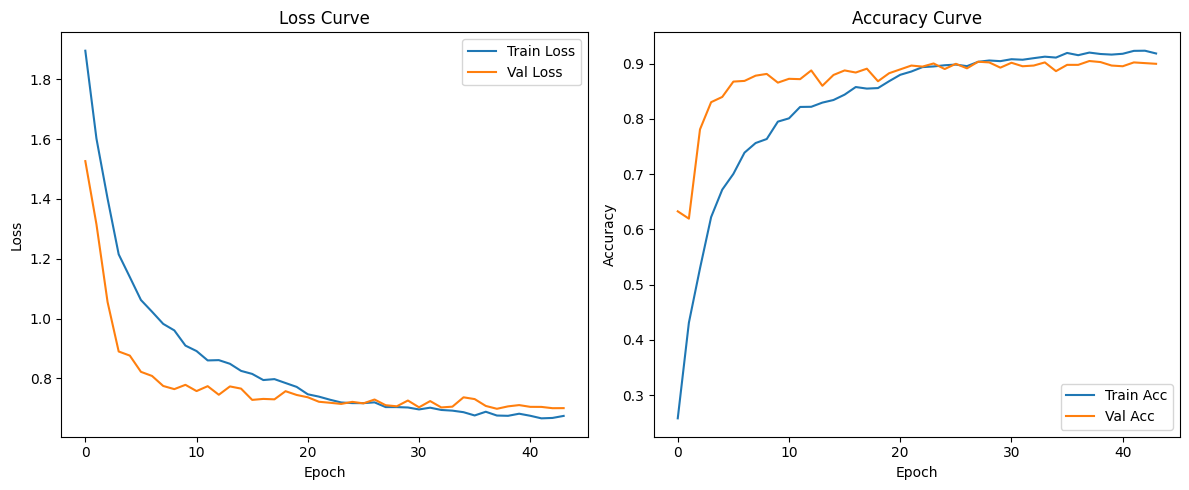


Per‑class classification report:

              precision    recall  f1-score   support

          AF     0.7115    0.5522    0.6218        67
        AFIB     0.8982    0.9251    0.9114       267
          AT     0.2917    0.5385    0.3784        13
          SA     0.4625    0.6066    0.5248        61
          SB     0.9678    0.9777    0.9727       584
          SR     0.9139    0.8109    0.8593       275
          ST     0.9528    0.9407    0.9467       236
         SVT     0.8298    0.8764    0.8525        89

    accuracy                         0.8932      1592
   macro avg     0.7535    0.7785    0.7585      1592
weighted avg     0.9012    0.8932    0.8955      1592

Accuracy    : 0.8932
Precision   : 0.7535
Recall      : 0.7785
F1_Score    : 0.7585
Roc_Auc     : 0.9707

Test Accuracy: 0.8932
Test ROC-AUC: 0.9707


In [9]:
def main():
    diagnostics_file = "/content/drive/MyDrive/Diagnostics.csv"
    ecg_folder       = "/content/drive/MyDrive/ECGDataDenoisedDownloaded"
    rhythm_names     = "/content/drive/MyDrive/RhythmNames.csv"

    tabular_features = []

    # Hyperparams
    batch_size   = 8
    epochs       = 100
    learning_rate= 9e-5
    weight_decay = 7e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Build DataLoaders with WeightedRandomSampler for the train set
    train_loader, val_loader, test_loader, full_dataset = get_stratified_dataloaders(
        diagnostics_file, ecg_folder, rhythm_names,
        batch_size=batch_size,
        tabular_features=tabular_features
    )

    num_classes = len(full_dataset.class_mapping)
    print(f"Number of classes in final dataset: {num_classes}")

    num_features = len(full_dataset.feature_cols)
    print(f"Number of numeric features: {num_features}")

    # Build the CNN
    model = ECGwithFeaturesModelV2(num_classes, num_features)

    # Train
    train_model(model, train_loader, val_loader,
                device, epochs=epochs, lr=learning_rate, weight_decay=weight_decay)

    # Evaluate
    class_names = sorted(full_dataset.class_mapping,
                     key=full_dataset.class_mapping.get)
    test_accuracy, test_roc_auc = evaluate_model(model, test_loader, num_classes, device, class_names=class_names)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    if test_roc_auc is not None:
        print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    else:
        print("ROC-AUC not computed (likely only one class).")

if __name__ == "__main__":
    main()


**Random Forest Model**
1. Build flat-vector signal only ECG dataset

2. Stratified 70/30 train-test split

3. Train class-balanced Random Forest (100 trees)

4. Predict on held-out test set

5. Evaluate on the held-out test set











In [ ]:
base_output_dir = "/content/drive/MyDrive/results"
rf_output_dir   = os.path.join(base_output_dir, "random_forest")
os.makedirs(rf_output_dir, exist_ok=True)

# Load dataset and flatten only the ECG signal
diagnostics_file = "/content/drive/MyDrive/Diagnostics.csv"
ecg_folder       = "/content/drive/MyDrive/ECGDataDenoisedDownloaded"
rhythm_names     = "/content/drive/MyDrive/RhythmNames.csv"
tabular_features = []

ds = ECGDatasetWithFeatures(diagnostics_file, ecg_folder, rhythm_names, tabular_features)

X, y = [], []
for i in range(len(ds)):
    sample = ds[i]
    sig    = sample["signal"].numpy()   # [12,5000]
    flat   = sig.reshape(-1)            # (60000,)
    X.append(flat)
    y.append(int(sample["label"]))

X = np.stack(X, axis=0)
y = np.array(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Fit Random Forest
clf = RandomForestClassifier(
    n_estimators   = 100,
    n_jobs         = -1,
    random_state   = 42,
    class_weight   = "balanced"
)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

# Classification report & core metrics
class_names = [rh for rh, idx in sorted(ds.class_mapping.items(), key=lambda x: x[1])]
report_str = classification_report(
    y_test, y_pred,
    target_names = class_names,
    digits       = 4,
    zero_division= 0
)
print("=== Classification Report ===\n")
print(report_str)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# Save classification report
with open(os.path.join(rf_output_dir, "classification_report.txt"), "w") as f:
    f.write(report_str)

# ROC-AUC (one-vs-rest, macro)
n_classes = len(class_names)
if n_classes > 1:
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    roc_auc    = roc_auc_score(y_test_bin, y_prob,
                               multi_class="ovr", average="macro")
    print(f"ROC-AUC  : {roc_auc:.4f}")
else:
    roc_auc = None
    print("ROC-AUC  : N/A (only one class)")

# Plot & save ROC curves
if roc_auc is not None:
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_prob[:,i])
        plt.plot(fpr, tpr,
                 label=f"{class_names[i]} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],"k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

    roc_path = os.path.join(rf_output_dir, "roc_curves.png")
    plt.savefig(roc_path)
    plt.show()

# Plot & save Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()

cm_path = os.path.join(rf_output_dir, "confusion_matrix.png")
plt.savefig(cm_path)
plt.show()

# Save summary metrics
metrics = {
    "accuracy" : acc,
    "precision": prec,
    "recall"   : rec,
    "f1_score" : f1,
    "roc_auc"  : roc_auc if roc_auc is not None else "N/A"
}
with open(os.path.join(rf_output_dir, "metrics.txt"), "w") as f:
    for k, v in metrics.items():
        f.write(f"{k}: {v}\n")


Loaded RhythmNames mapping: {'SA': 'Sinus Arrhythmia', 'SB': 'Sinus Bradycardia', 'SR': 'Sinus Rhythm', 'AFIB': 'Atrial Fibrillation', 'ST': 'Sinus Tachycardia', 'AF': 'Atrial Flutter', 'SVT': 'Supraventricular Tachycardia', 'AT': 'Atrial Tachycardia', 'AVNRT': 'Atrioventricular  Node Reentrant Tachycardia', 'AVRT': 'Atrioventricular Reentrant Tachycardia', 'SAAWR': 'Sinus Atrium to Atrial Wandering Rhythm'}
Final included rhythms (each >= 120 total):
  - AF: 438 rows
  - AFIB: 1780 rows
  - AT: 121 rows
  - SA: 397 rows
  - SB: 3888 rows
  - SR: 1825 rows
  - ST: 1564 rows
  - SVT: 584 rows
Built label mapping: {'AF': 0, 'AFIB': 1, 'AT': 2, 'SA': 3, 'SB': 4, 'SR': 5, 'ST': 6, 'SVT': 7}
Using these feature columns: []
